In [ ]:
# import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
# import os
# import pandas as pd
from analysis_functions import *

In [2]:
from analysis_functions import *

In [3]:
# image = r'C:\Users\Willi\Desktop\134L Images\good_fits\van_Maanen_g.fits'
image = r'C:\Users\admin1\OneDrive\Desktop\134L Images\good_fits\van_Maanen_g.fits'
hdul = fits.open(image)
image = hdul[1].data

# if not os.path.isfile(image):
#     print('File not found')

Calculate temperature using color index data

Try with just the imported functions.

In [4]:
# file_root = r'C:\Users\Willi\Desktop\134L Images\good_fits'
file_root = r'C:\Users\admin1\OneDrive\Desktop\134L Images\good_fits'

In [46]:
def calculate_luminosity(absolute_mag, solar_luminosity=3.846e26, solar_absolute_mag=4.83):
    """
    Calculate the luminosity of a star given its absolute magnitude.
    
    Parameters:
        absolute_mag (float): The absolute magnitude of the star.
        solar_luminosity (float): Luminosity of the Sun in watts (default: 3.828e26 W).
        solar_absolute_mag (float): Absolute magnitude of the Sun (default: 4.83).
    
    Returns:
        float: Luminosity of the star in watts.
    """
    luminosity = solar_luminosity * 10**(0.4 * (solar_absolute_mag - absolute_mag))

    return luminosity

In [47]:
calculate_luminosity(11.3)

9.931372693180644e+23

Final evaluations

In [33]:
data = calculate_all(file_root, 'omi02EriB_', 1208, 1225, 8, 5) # good
apparent_mag1 = data[1]
absolute_mag1 = data[2]
luminosity1 = data[3]
temp1 = data[4]
print(apparent_mag1, absolute_mag1, luminosity1, temp1)
# bad: 1213, 1233

[ 9.78007223 10.00158909 10.16225079] [11.2852222  11.50673907 11.66740077] [1.00674713e+24 8.20944225e+23 7.08025616e+23] [17000. 22200. 18500.]


In [34]:
data = calculate_all(file_root, 'WD0621-376_', 1166, 1259, 8, 76.7) # mag is good, temp is bad
apparent_mag2 = data[1]
absolute_mag2 = data[2]
luminosity2 = data[3]
temp2 = data[4]
print(apparent_mag2, absolute_mag2, luminosity2, temp2)
# temp should be around 66000, mag 12.1

[12.21520916 12.70695636 13.06846054] [7.79123234 8.28297954 8.64448372] [2.51487465e+25 1.59888586e+25 1.14608227e+25] [100000. 100000. 100000.]


In [35]:
data = calculate_all(file_root, 'LHS_253_', 1251, 1175, 8, 8.52) # good
apparent_mag3 = data[1]
absolute_mag3 = data[2]
luminosity3 = data[3]
temp3 = data[4]
print(apparent_mag3, absolute_mag3, luminosity3, temp3)

[12.2877662  12.26923754 12.35831156] [12.63556823 12.61703957 12.70611359] [2.90256523e+23 2.95252412e+23 2.71996831e+23] [10500. 14900. 11700.]


In [36]:
data = calculate_all(file_root, 'LAWD_8_', 1208, 1216, 8, 16.76) # good
apparent_mag4 = data[1]
absolute_mag4 = data[2]
luminosity4 = data[3]
temp4 = data[4]
print(apparent_mag4, absolute_mag4, luminosity4, temp4)

[14.18279463 14.231414   14.37469643] [13.06142455 13.11004393 13.25332636] [1.96082781e+23 1.87495871e+23 1.64315577e+23] [11700. 19700. 13500.]


In [37]:
data = calculate_all(file_root, 'van_Maanen_', 1189, 1173, 8, 4.3) # good
apparent_mag5 = data[1]
absolute_mag5 = data[2]
luminosity5 = data[3]
temp5 = data[4]
print(apparent_mag5, absolute_mag5, luminosity5, temp5)

[12.96293269 12.69025376 12.65932917] [14.79559041 14.52291148 14.49198689] [3.96984103e+22 5.10322467e+22 5.25066756e+22] [7600. 9900. 8300.]


In [38]:
data = calculate_all(file_root, 'LAWD_74_', 1132, 1160, 8, 10.5) # good
apparent_mag6 = data[1]
absolute_mag6 = data[2]
luminosity6 = data[3]
temp6 = data[4]
print(apparent_mag6, absolute_mag6, luminosity6, temp6)
# should be around 12, 10000

[12.6776274  12.79920104 12.99777499] [12.5716809  12.69325455 12.89182849] [3.07848414e+23 2.75237409e+23 2.29233394e+23] [13400. 31000. 16500.]


In [39]:
data = calculate_all(file_root, 'WD0005+511_', 1220, 1190, 8, 415) # good
apparent_mag7 = data[1]
absolute_mag7 = data[2]
luminosity7 = data[3]
temp7 = data[4]
print(apparent_mag7, absolute_mag7, luminosity7, temp7)

[13.4311866  13.90627089 14.28815706] [5.34094611 5.8160304  6.19791658] [2.40231988e+26 1.55094758e+26 1.09104496e+26] [ 80900. 100000. 100000.]


In [40]:
data = calculate_all(file_root, 'WD0501-289_', 1195, 1242, 8, 138) # good
apparent_mag8 = data[1]
absolute_mag8 = data[2]
luminosity8 = data[3]
temp8 = data[4]
print(apparent_mag8, absolute_mag8, luminosity8, temp8)

[14.00380044 14.51867462 14.9228158 ] [8.30440501 8.81927919 9.22342037] [1.56764340e+25 9.75657986e+24 6.72420792e+24] [100000. 100000. 100000.]


In [41]:
data = calculate_all(file_root, 'GJ283A_', 1195, 1197, 8, 9.15) # good. should be 13, 7500
apparent_mag9 = data[1]
absolute_mag9 = data[2]
luminosity9 = data[3]
temp9 = data[4]
print(apparent_mag9, absolute_mag9, luminosity9, temp9)
# original coords: 1225, 1225, doesn't look right

[13.48435603 13.41822226 13.46107031] [13.67725056 13.61111679 13.65396484] [1.11201093e+23 1.18185056e+23 1.13611775e+23] [ 9800. 12400. 10500.]


In [42]:
data = calculate_all(file_root, 'GJ1015B_', 1217, 1190, 8, 22.9) # good
apparent_mag10 = data[1]
absolute_mag10 = data[2]
luminosity10 = data[3]
temp10 = data[4]
print(apparent_mag10, absolute_mag10, luminosity10, temp10)

[14.39658235 14.49952017 14.69415733] [12.59740494 12.70034276 12.89497991] [3.00640375e+23 2.73446378e+23 2.28568993e+23] [12900. 29700. 15900.]


In [43]:
data = calculate_all(file_root, 'GJ440_', 1128, 1237, 8, 4.64) # good. should be 11.5, 8000
apparent_mag11 = data[1]
absolute_mag11 = data[2]
luminosity11 = data[3]
temp11 = data[4]
print(apparent_mag11, absolute_mag11, luminosity11, temp11)
# original coords: 1180, 1187, doesn't look right

[11.93851155 11.81595994 11.94363828] [13.60592164 13.48337004 13.61104838] [1.18751915e+23 1.32941711e+23 1.18192503e+23] [ 9100. 18000. 10900.]


In [44]:
data = calculate_all(file_root, 'WD0615-59_', 1133, 1256, 8, 36.06) # good
apparent_mag12 = data[1]
absolute_mag12 = data[2]
luminosity12 = data[3]
temp12 = data[4]
print(apparent_mag12, absolute_mag12, luminosity12, temp12)

[14.28232563 14.59353102 14.89489544] [11.49719702 11.80840241 12.10976683] [8.28190933e+23 6.21796563e+23 4.71088551e+23] [ 22900. 100000.  36400.]


Now plot the data.

In [67]:
solar_luminosity = 3.846e26

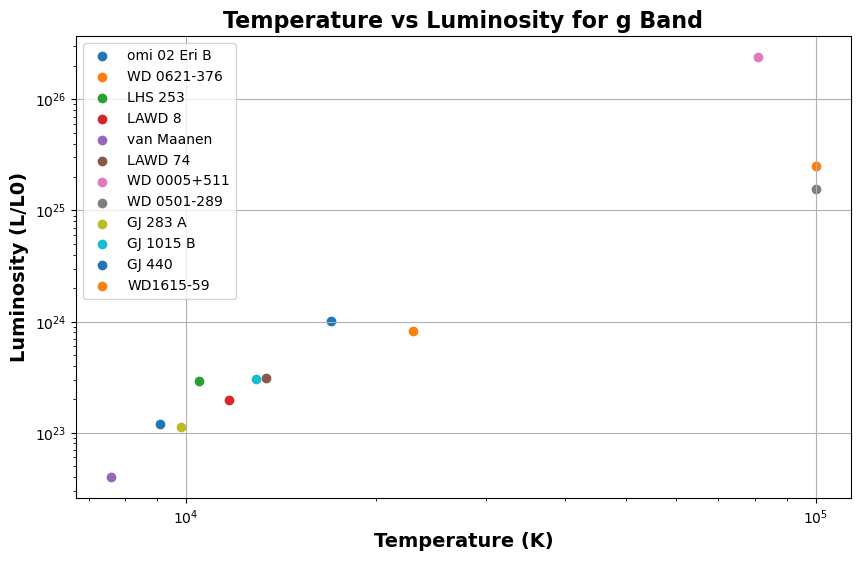

In [61]:
temperatures = []
luminosities = []
star_names = ['omi 02 Eri B', 'WD 0621-376', 'LHS 253', 'LAWD 8', 'van Maanen', 'LAWD 74', 'WD 0005+511', 'WD 0501-289', 'GJ 283 A', 'GJ 1015 B', 'GJ 440', 'WD1615-59']

for i in range(1, 13):
    temp = globals()[f'temp{i}']
    luminosity = globals()[f'luminosity{i}']
    temperatures.append(temp[0])
    luminosities.append(luminosity[0]) # g band

plt.figure(figsize=(10, 6))

for i, name in enumerate(star_names):
    plt.scatter(temperatures[i], luminosities[i], label=name)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Temperature (K)', fontweight='bold', fontsize=14)
plt.ylabel('Luminosity (L/L0)', fontweight='bold', fontsize=14)
plt.title('Temperature vs Luminosity for g Band', fontsize=16, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

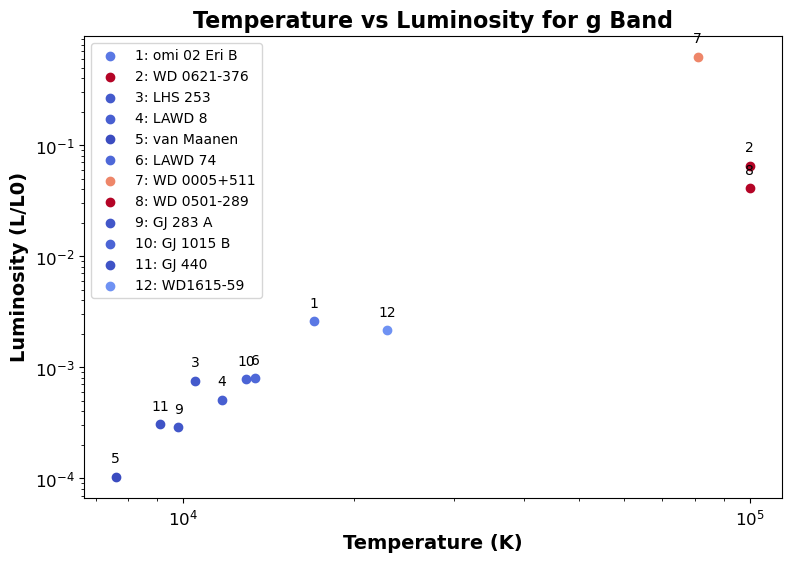

In [75]:
temperatures = []
luminosities = []
star_names = ['omi 02 Eri B', 'WD 0621-376', 'LHS 253', 'LAWD 8', 'van Maanen', 'LAWD 74', 'WD 0005+511', 'WD 0501-289', 'GJ 283 A', 'GJ 1015 B', 'GJ 440', 'WD1615-59']

for i in range(1, 13):
    temp = globals()[f'temp{i}']
    luminosity = globals()[f'luminosity{i}']
    temperatures.append(temp[0])
    luminosities.append(luminosity[0]/solar_luminosity) # g band, normalize by solar luminosity

# Normalize temperatures for colormap
norm = plt.Normalize(min(temperatures), max(temperatures))
cmap = plt.get_cmap('coolwarm')

plt.figure(figsize=(9, 6))

for i, name in enumerate(star_names):
    plt.scatter(temperatures[i], luminosities[i], color=cmap(norm(temperatures[i])), label=f'{i+1}: {name}')
    plt.annotate(i+1, (temperatures[i], luminosities[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Temperature (K)', fontweight='bold', fontsize=14)
plt.ylabel('Luminosity (L/L0)', fontweight='bold', fontsize=14)
plt.title('Temperature vs Luminosity for g Band', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=10)
plt.show()